
# Introduction to Aperture Photometry

This notebook will help you understand how to perform aperture photometry in python using the `photutils` package along with a few related pieces of information.

1. [What is Photometry (In General)](#what-is-photometry)
1. [What is Aperture Photometry](#what-is-aperture-photometry)
1. [Reading FITS Files](#reading-fits-files)
1. [Coordinates in an Image](#coordinates-in-an-image)
1. [Performing Photometry](#performing-photometry)
1. How to subtract the background flux from your results

## What is Photometry (In General) <a class="anchor" id="what-is-photometry"></a>

Photometry is a process by which we determine the energy output of a star or other visible object. Unlike spectra, which classify the energy output of a single object per wavelength, photometric observations are images taken of multiple objects over a range of wavelengths. 

These wavelength ranges are also refered to as *bands*, and have standardized letter names. For example, H band goes from 1.5 to 1.8 micrometers. To observe in a particular band, a telescope observer will use a filter that only lets light within the band pass through the telescope. After light has passed through the filter, the optics in the telescope guide the light onto a CCD sensor.

This sensor is much the same as those found in a common digital camera. The sensor is broken up into a grid of pixels. When a photon hits a pixel, it releases an electron. By counting the number of electrons in each pixel, we can determine the number of photons that landed at that part of the sensor. This value is typically recorded either in units of total photon counts or as counts per second.

It is important to note that photometric images are different from those taken by a normal camera. In a photometric image each pixel doesn't represent a color, it represents a number of photons (possibly per second). Color can be added to the image after the fact, but we are only concerned with the photon counts.

Note: you may come across other images where pixel values are recorded in other units (ergs, nanomaggies, etc.). Be careful, don't assume!

## What is Aperture Photometry <a class="anchor" id="what-is-aperture-photometry"></a>

Aperture photometry is a process by which we analyze a photometric image. In essence, we begin by drawing an aperture around an object in the image. To determine the energy output of the object, we then count the number of photons that fell within the aperture.

Imagine a sphere surrounding the object you’re looking at. Also, image that this sphere has a radius that is the same as your distance from the object, so that you are on the surface of this sphere. The aperture you drew on the image only covers a small portion of the surface area of the sphere. If we assume that the object emits photons evenly in all directions, we can then determine the total photon emissions as

$\ \ \ \ Total\ Counts = \frac{Counts\ in\ aperture}{Aperture\ Area} * Total\ Area = \frac{CPS}{Aperture\ Area} * \pi r^2$

Where $r$ is the radius of the imaginary sphere, or equivalently, your distance from the object.

The size of your aperture is an important decision. Too small of an aperture means you might not be including the entire object you’re interested in. However, too large an aperture means your including more background noise and possibly even another object. In general, the aperture size you use will depend on the type of object you want to look at and the images themselves.

## Reading FITS Files <a class="anchor" id="reading-fits-files"></a>

First, let’s get some technical jargon out of the way.

The Flexible Image Transport System (FITS) is a file format that is commonly used in astronomy to store and share image data. A FITS file can be thought of as a collection of one or more tables called Header Data Units (HDUs). The `astropy` package makes reading these tables extremely easy


In [1]:
from astropy.io import fits
hdu_list = fits.open("example.fits") # Creates a list of the HDUs in the file
hdu_list.info()


Filename: example.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     161   (891, 893)   int16   
  1  er.mask     TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


To make things simple, our example file only has two HDUs, but depending on the file you read there may be several. In most cases we are usually interested in the first, or "primary" HDU.

Each HDU has two parts - the actual data, and a header that stores useful information. The data is stored as an array, where each element in that array represents the value of a corresponding pixel. Here are a few examples:

These are the first 10 entries in the header:

SIMPLE  =                    T /FITS: Compliance                                
BITPIX  =                   16 /FITS: I*2 Data                                  
NAXIS   =                    2 /FITS: 2-D Image Data                            
NAXIS1  =                  891 /FITS: X Dimension                               
NAXIS2  =                  893 /FITS: Y Dimension                               
EXTEND  =                    T /FITS: File can contain extensions               
DATE    = '2014-01-09        '  /FITS: Creation Date                            
ORIGIN  = 'STScI/MAST'         /GSSS: STScI Digitized Sky Survey                
SURVEY  = 'SERC-ER '           /GSSS: Sky Survey                                
REGION  = 'ER768   '           /GSSS: Region Name                               

The value of 'BITPIX' from the header is: 16

Here is a nice plot of the image.



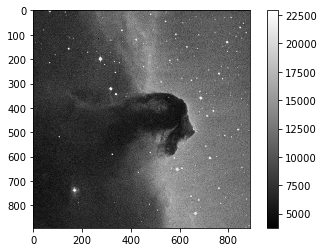

In [2]:
from matplotlib import pyplot as plt

primary_hdu = hdu_list[0]
header = primary_hdu.header
data = primary_hdu.data

print("These are the first 10 entries in the header:\n")
print(repr(header[:10]))

# You can access each entry in the header individualy.
print("\nThe value of 'BITPIX' from the header is:", header['BITPIX'])

print("\nHere is a nice plot of the image.\n")
plt.imshow(primary_hdu.data, cmap='gray')
plt.colorbar()
plt.show()

## Coordinates in an image <a class="anchor" id="coordinates-in-an-image"></a>

The position of objects in an astronomical image are typically represented in either pixel coordinates or in celestial coordinates. Converting between these unit systems requires knowing the World Coordinate System (WCS) for a particular image. This information is usually stored within the FITS file itself.

The `astropy.coordinates.SkyCoord` module has a lot of useful tools for converting between various coordinate systems, but we won't talk about them all here. Instead here are a few short examples.

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

hdu_list = fits.open("example.fits")
primary_hdu = hdu_list[0]

# This retrieves the WCS information from the image
image_wcs = WCS(primary_hdu)

# Create a coordinate object from units of degrees
coord_from_degrees = SkyCoord(85, -2.5, unit=('deg'))
print(coord_from_degrees, '\n')

# Create a coordinate in celestial units
coord_from_hourangle = SkyCoord("1:12:43.2", "+1:12:43", unit=u.hourangle)
print(coord_from_hourangle, '\n')

# Create a coordinate object from pixel values
cord_from_pixel = SkyCoord.from_pixel(170, 740, image_wcs)
print(cord_from_pixel, '\n')

# We can also convert the coordinates back to pixel values
print(cord_from_pixel.to_pixel(image_wcs))


<SkyCoord (ICRS): (ra, dec) in deg
    ( 85., -2.5)> 

<SkyCoord (ICRS): (ra, dec) in deg
    ( 18.18,  18.17916667)> 

<SkyCoord (ICRS): (ra, dec) in deg
    ( 85.35221932, -2.37611935)> 

(array(170.00000000000313), array(740.0000000000109))


Notice that no matter how we specify the coordinates, `SkyCoord` internally stores the coordinates in units of degrees.

## Performing Photometry <a class="anchor" id="performing-photometry"></a>


Lets create an aperture.

The `photutils` package provides apertures of a few different aerture shapes (circle, oval, rectangular, annulus, etc.). We will be using the circular shaped aperture.

For conveniance, all of the `photutils` apertures come in pairs - one for pixel coordinates, and one for sky coordinates. For example, if you want a circular aperture in pixel coordinates, you would use the `CircularAperture` object. If you were working in sky coordinates, you would use the `SkyCircularAperture` object. 

As an example, lets perform photometry on the bright star in the lower left corner of the example image.

In [4]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from photutils import aperture_photometry, SkyCircularAperture

hdu_list = fits.open("example.fits")
primary_hdu = hdu_list[0]

# The radius should be dimensionful
aperture_radius = 1 * u.arcsec
aperture_coord = SkyCoord(85.35221932, -2.37611935, unit=('deg'))

comp_aperture = SkyCircularAperture(aperture_coord, aperture_radius)
aperture_photometry(primary_hdu, comp_aperture)

id,xcenter,ycenter,celestial_center,aperture_sum
,pix,pix,,
int64,float64,float64,object,float64
1,170.00000221002958,739.9999928908001,"<SkyCoord (ICRS): (ra, dec) in deg ( 85.35221932, -2.37611935)>",68075.510963


The `aperture_photometry` function returns an astropy table with the coordinates of the aperture (in pixels and celestial coordinates) and the the sum of pixel values within the aperture.

For reference, here is what the aperture looks like when drawn on the image:

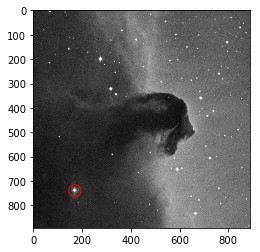

In [8]:
from matplotlib.patches import Circle
fig,ax = plt.subplots(1)
ax.imshow(primary_hdu.data, cmap='gray')
circ = Circle((170, 740), 25, facecolor='None', edgecolor='r', lw=1)
ax.add_patch(circ)
plt.show()

In [9]:
# Todo - use the actual radius of the aperture and correct coordinates in the demo image
# Todo - subtract background using an annulus?
# Todo - determine the total flux
